## Instalando e Carregando Pacotes

In [ ]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.11.4


In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

**ATENÇÃO**:

https://pypi.org/project/torchvision/

https://pypi.org/project/torch/

In [ ]:
!pip install -q torch==2.0.0

In [ ]:
!pip -q install torchvision==0.15.1

In [ ]:
# https://pypi.org/project/timm/
!pip -q install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.7 MB/s eta 0:00:00


In [ ]:
# https://pypi.org/project/vit-pytorch/
# https://pypi.org/project/linformer/
!pip -q install vit_pytorch linformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.6/93.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.9 MB/s eta 0:00:00


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!chmod 600 /content/kaggle.json


!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
!unzip /content/tuberculosis-tb-chest-xray-dataset.zip -d /content/kaggle/

Archive:  /content/tuberculosis-tb-chest-xray-dataset.zip
  inflating: /content/kaggle/TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: /content/kaggle/TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: /content/kaggle/TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: /content/kaggle/TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: /content/kaggle/TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: /content/kaggle/TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: /content/kaggle/TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: /content/kaggle/TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: /content/kaggle/TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: /content/kaggle/TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: /content/kaggle/TB_Chest_Radiography_Database/Normal/Normal-1006.png  
  inflating: /content/kagg

https://arxiv.org/abs/2006.04768

In [ ]:
# Imports
import os
import copy
import math
import torch
import timm
import torchvision
import pandas as pd
import numpy as np
from linformer import Linformer
from vit_pytorch.efficient import ViT
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from torch import optim, nn
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Version 0" --iversions

Author: Data Science Academy

timm       : 0.9.6
pandas     : 2.1.0
numpy      : 1.24.3
matplotlib : 3.7.1
sklearn    : 1.3.0
torchvision: 0.15.1
torch      : 2.0.0
seaborn    : 0.12.2



In [ ]:
# Define o Device (uso de GPU não é requerido para este projeto)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

## Pré-Processamento das Imagens

Organize as imagens em disco conforme mostrado nas aulas em vídeo.

In [ ]:
# Pasta de imagens
data_dir = "/content/kaggle/TB_Chest_Radiography_Database"

In [ ]:
# Dataset de imagens
dataset_completo = datasets.ImageFolder(data_dir)

In [ ]:
dataset_completo

Dataset ImageFolder
    Number of datapoints: 4200
    Root location: /content/kaggle/TB_Chest_Radiography_Database

In [ ]:
# Nomes das classes
class_names = dataset_completo.classes
print(class_names)

['Normal', 'Tuberculosis']


In [ ]:
# Define o tamanho dos datasets
full_size = len(dataset_completo)
train_size = int(0.7 * full_size)
val_size = full_size - train_size

In [ ]:
# Randomicamente divide as imagens nas amostras de dados
torch.manual_seed(0)
train_dataset, val_dataset = torch.utils.data.random_split(dataset_completo, [train_size, val_size])

In [ ]:
# Tamanhos dos datasets
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [ ]:
dataset_sizes

{'train': 2940, 'val': 1260}

In [ ]:
# Processamento das imagens
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Aplica as transformações aos dados de treino
train_dataset.dataset.transform = data_transforms['train']

https://arxiv.org/pdf/2010.11929.pdf

In [ ]:
# Tamanho do batch
batch_size = 32

In [ ]:
# Cria os dataloaders
# Nota: se tiver erro aqui, remova o parâmetro num_workers
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = batch_size,
                                               shuffle = True,
                                               num_workers = 4)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size = batch_size,
                                             shuffle = True,
                                             num_workers = 4)

In [ ]:
# Dataloaders
dataloaders = {'train': train_dataloader, 'val': val_dataloader}

## Visualizando as Imagens

In [ ]:
# Obtém um batch de dados de treino
inputs, labels = next(iter(train_dataloader))

In [ ]:
# Converte o batch em tensor numpy
inputs = inputs.numpy()
labels = labels.numpy()

In [ ]:
# Nomes das categorias
label_names = [class_names[label] for label in labels]

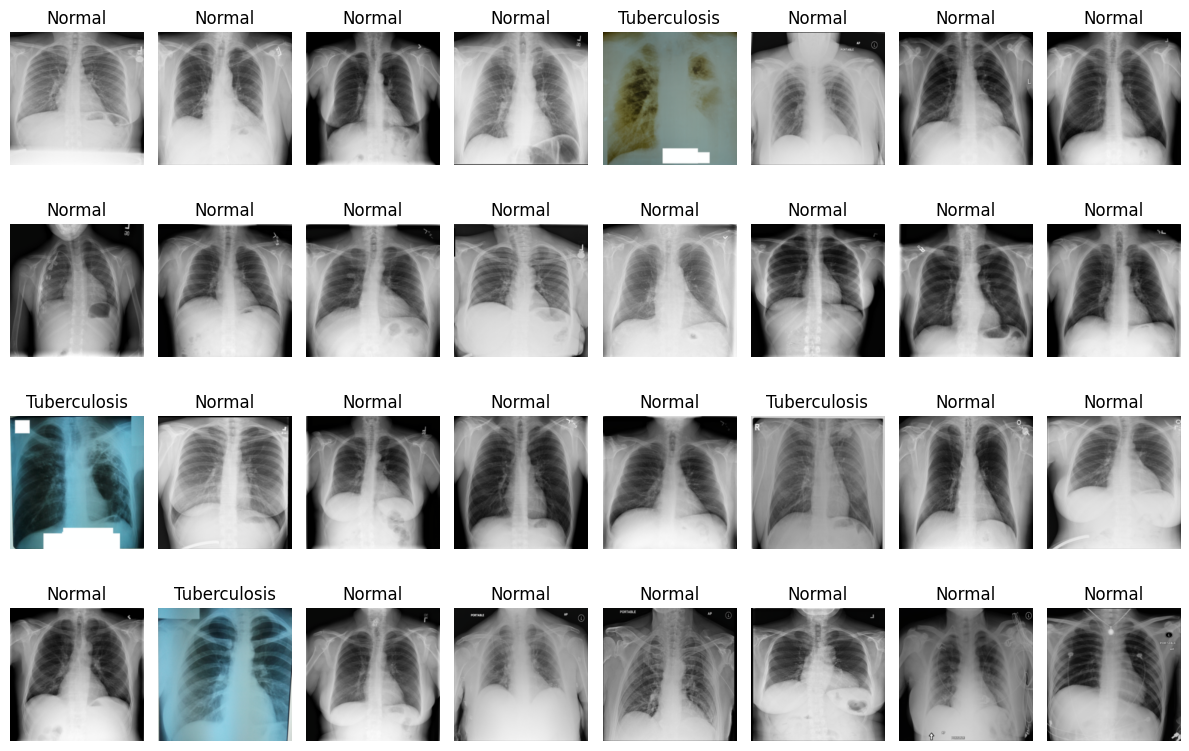

In [ ]:
# Visualiza imagens e labels
fig, axes = plt.subplots(figsize = (12, 8), nrows = 4, ncols = 8)
axes = axes.flatten()

# Loop for
for i, (image, label) in enumerate(zip(inputs, label_names)):
    image = np.transpose(image, (1, 2, 0))
    image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    image = np.clip(image, 0, 1)
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(label)

plt.tight_layout()
plt.show()

## Modelagem - Carregando o Modelo ViT Pré-Treinado

https://timm.fast.ai/

https://huggingface.co/timm

In [ ]:
# Carregando modelo pré-treinado
modelo = timm.create_model('vit_base_patch16_224', pretrained = True)

In [ ]:
# Número de atributos
num_ftrs = modelo.head.in_features

In [ ]:
num_ftrs

768

In [ ]:
# Modifica a última camada de acordo com a tarefa de classificação
modelo.head = nn.Linear(num_ftrs, len(class_names))

In [ ]:
# Envia o modelo para o device
modelo = modelo.to(device)

In [ ]:
# Calcula o número de parâmetros do modelo
model_parameters = filter(lambda p: p.requires_grad, modelo.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
params

85800194

**Precisamos de todos esses parâmetros para nosso caso de uso?**

In [ ]:
# Sumário
print(modelo)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

## Modelagem - Linformer Para Customização Eficiente do Modelo ViT

https://arxiv.org/pdf/2006.04768.pdf

In [ ]:
# Atributos de entrada
in_features = 128

In [ ]:
# Cria o objeto Linformer com os parâmetros de customização
efficient_transformer = Linformer(dim = in_features, seq_len = 49+1, depth = 12, heads = 8, k = 64)

Essa linha de código acima está inicializando um modelo Linformer, que é uma variante mais eficiente do modelo de Transformer.

- dim = in_features: Define a dimensão dos embeddings de entrada.
- seq_len = 49+1: Define o comprimento máximo da sequência que o modelo pode aceitar. Aqui, é 50.
- depth = 12: Especifica o número de camadas (ou "profundidade") do modelo.
- heads = 8: Especifica o número de "cabeças" no mecanismo de atenção multi-cabeça.
- k = 64: É um parâmetro específico do Linformer que define o tamanho da janela de contexto para a atenção linearizada.

In [ ]:
# Define o modelo com os parâmetros de customização
modelo = ViT(dim = in_features,
             image_size = 224,
             patch_size = 32,
             num_classes = 2,
             transformer = efficient_transformer,
             channels = 3)

Parâmetros:

- dim = in_features: Define a dimensão dos embeddings de entrada para o transformador.
- image_size = 224: Especifica o tamanho da imagem de entrada (224x224 pixels).
- patch_size = 32: Define o tamanho de cada "patch" em que a imagem será dividida. Uma imagem 224x224 será dividida em patches de 32x32 pixels.
- num_classes = 2: Especifica o número de classes na tarefa de classificação. Aqui, há duas classes.
- transformer = efficient_transformer: Utiliza o modelo efficient_transformer (um modelo Linformer) como o núcleo transformador do ViT.
- channels = 3: Indica o número de canais na imagem de entrada, que é 3 para imagens coloridas em formato RGB.

Logo, essa linha cria um Vision Transformer para classificação de imagens de tamanho 224x224 em duas classes, usando patches de 32x32 pixels, com um transformador Linformer fornecido (efficient_transformer) e assumindo imagens de entrada em formato RGB.

In [ ]:
# Número de atributos
num_ftrs = in_features

In [ ]:
num_ftrs

128

In [ ]:
# Modificamos a última camada de acordo com a tarefa de classificação
modelo.head = nn.Linear(num_ftrs, len(class_names))

In [ ]:
# Envia o modelo para o device
modelo = modelo.to(device)

In [ ]:
# Calcula o número de parâmetros do modelo
model_parameters = filter(lambda p: p.requires_grad, modelo.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
params

2858500

In [ ]:
# Sumário
print(modelo)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): Fe

## Treinamento do Modelo ViT Customizado

In [ ]:
# Função de erro
criterion = nn.CrossEntropyLoss()

In [ ]:
# Otimizador
optimizer = optim.Adam(modelo.parameters(), lr = 3e-5)

In [ ]:
# Learning rate scheduler
exp_lr_scheduler = StepLR(optimizer, step_size = 7, gamma = 0.1)

In [ ]:
# Parâmetros de controle
num_epochs = 15
best_model_wts = copy.deepcopy(modelo.state_dict())
best_acc = 0.0

In [ ]:
# Listas para o histórico de treino
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

In [ ]:
%%time
for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Define qual fase estamos, treino ou validação
    for phase in ['train', 'val']:
        if phase == 'train':
            modelo.train()
        else:
            modelo.eval()

        # Contadores
        running_loss = 0.0
        running_corrects = 0

        # Iteração pelos dados
        for inputs, labels in dataloaders[phase]:

            # Envia imagens e labels para o device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zera os gradientes
            optimizer.zero_grad()

            # Forward propagation
            with torch.set_grad_enabled(phase == 'train'):

                # Faz as previsões com o modelo
                outputs = modelo(inputs)

                # Obtém a maior probabilidade de classe
                _, preds = torch.max(outputs, 1)

                # Calcula o erro
                loss = criterion(outputs, labels)

                # Backpropagation e optimization somente em treino
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Calcula as estatísticas
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calcula erro e acurácia
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()

        # Grava o histórico
        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc)
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc)

        print('{} - Erro: {:.4f} Acurácia: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # Deep copy do modelo
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(modelo.state_dict())

    print()

print('\nMelhor Acurácia em Validação: {:4f}'.format(best_acc))
print('\nTreinamento Concluído')

Epoch 0/14
----------
train - Erro: 0.4921 Acurácia: 0.7918
val - Erro: 0.4096 Acurácia: 0.8349

Epoch 1/14
----------
train - Erro: 0.3054 Acurácia: 0.8684
val - Erro: 0.1487 Acurácia: 0.9476

Epoch 2/14
----------
train - Erro: 0.1224 Acurácia: 0.9578
val - Erro: 0.1089 Acurácia: 0.9635

Epoch 3/14
----------
train - Erro: 0.1012 Acurácia: 0.9694
val - Erro: 0.1290 Acurácia: 0.9540

Epoch 4/14
----------
train - Erro: 0.0797 Acurácia: 0.9697
val - Erro: 0.0822 Acurácia: 0.9738

Epoch 5/14
----------
train - Erro: 0.0757 Acurácia: 0.9707
val - Erro: 0.0803 Acurácia: 0.9754

Epoch 6/14
----------
train - Erro: 0.0504 Acurácia: 0.9847
val - Erro: 0.0819 Acurácia: 0.9722

Epoch 7/14
----------
train - Erro: 0.0428 Acurácia: 0.9861
val - Erro: 0.0745 Acurácia: 0.9778

Epoch 8/14
----------
train - Erro: 0.0403 Acurácia: 0.9878
val - Erro: 0.0936 Acurácia: 0.9714

Epoch 9/14
----------
train - Erro: 0.0293 Acurácia: 0.9905
val - Erro: 0.0842 Acurácia: 0.9794

Epoch 10/14
----------
train -

## Avaliação do Modelo

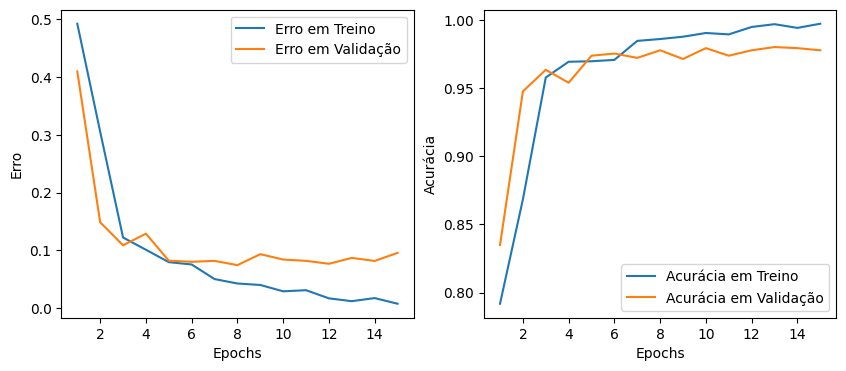

In [ ]:
# Época
epoch = range(1, len(train_loss_history)+1)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(epoch, train_loss_history, label = 'Erro em Treino')
ax[0].plot(epoch, val_loss_history, label = 'Erro em Validação')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Erro')
ax[0].legend()

ax[1].plot(epoch, train_acc_history, label = 'Acurácia em Treino')
ax[1].plot(epoch, val_acc_history, label = 'Acurácia em Validação')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acurácia')
ax[1].legend()

In [ ]:
# Função para o plot da confusion matrix
def plot_cm(labels, predictions):

    conf_numpy = confusion_matrix(labels, predictions)
    conf_df = pd.DataFrame(conf_numpy, index = class_names, columns = class_names)
    plt.figure(figsize = (8,7))
    sns.heatmap(conf_df, annot = True, fmt = "d", cmap = "BuPu")
    plt.title('Confusion Matrix', fontsize = 15)
    plt.ylabel('Valor Real', fontsize = 14)
    plt.xlabel('Valor Previsto', fontsize = 14)

In [ ]:
# Função para avaliar o modelo
def evaluate_model(model, dataloader, device):

    # Coloca o modelo em modo de avaliação
    modelo.eval()

    # Listas
    true_labels = []
    pred_labels = []

    # Faz as previsões a partir dos dados
    for inputs, labels in dataloader:

        # Envia imagens e labels para o device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward
        with torch.no_grad():
            outputs = modelo(inputs)
            _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    return true_labels, pred_labels

In [ ]:
# Extrai valores reais e previsões de labels
true_labels, pred_labels = evaluate_model(modelo, dataloaders['val'], device)

In [ ]:
# Calcula a confusion matrix
cm_val = confusion_matrix(true_labels, pred_labels)
a_val = cm_val[0,0]
b_val = cm_val[0,1]
c_val = cm_val[1,0]
d_val = cm_val[1,1]

In [ ]:
# Calcula as métricas de performance

# Accuracy
acc_val = (a_val + d_val) / (a_val + b_val + c_val + d_val)

# Error rate
error_rate_val = 1 - acc_val

# Sensitivity
sen_val = d_val/(d_val + c_val)

# Specificity
sep_val = a_val/(a_val + b_val)

# Precision
precision_val = d_val / (b_val + d_val)

# F1 score
F1_val = (2 * precision_val * sen_val) / (precision_val + sen_val)

# Coeficiente de Correlação de Matthews
MCC_val = (d_val*a_val-b_val*c_val) / (np.sqrt((d_val+b_val)*(d_val+c_val)*(a_val+b_val)*(a_val+c_val)))

In [ ]:
# Print
print("\n Sensitivity em validação:", sen_val,
      "\n Specificity em validação:", sep_val,
      "\n Accuracy em validação:", acc_val,
      "\n Error rate em validação:", error_rate_val,
      "\n Precision em validação:", precision_val,
      "\n F1 score em validação:", F1_val,
      "\n Matthews Correlation Coefficient (MCC) em validação:", MCC_val)


 Sensitivity em validação: 0.8894230769230769 
 Specificity em validação: 0.9952471482889734 
 Accuracy em validação: 0.9777777777777777 
 Error rate em validação: 0.022222222222222254 
 Precision em validação: 0.9736842105263158 
 F1 score em validação: 0.9296482412060302 
 Matthews Correlation Coefficient (MCC) em validação: 0.9178088874829493


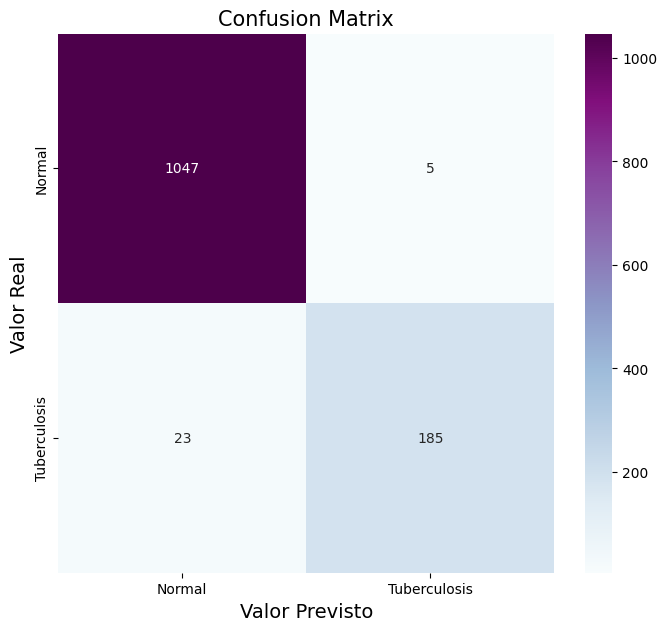

In [ ]:
# Confusion matrix
plot_cm(true_labels, pred_labels)

In [ ]:
# Garantimos que o modelo esteja em modo de avaliação
modelo.eval()

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): Fe

In [ ]:
# Dataloader de validação
val_ds = dataloaders['val']

In [ ]:
# Listas para calcular AUC (Area Under The Curve)
val_pre_auc   = []
val_label_auc = []

In [ ]:
# Loop para iterar através do conjunto de dados de validação (val_ds)
for images, labels in val_ds:

    # Loop para iterar através de cada par de imagem e label no lote atual
    for image, label in zip(images, labels):

        # Adiciona uma dimensão extra, move a imagem para o dispositivo (geralmente uma GPU) e armazena em 'img_array'
        img_array = image.unsqueeze(0).to(device)

        # Utiliza o modelo para fazer uma previsão na imagem e armazena o resultado em 'prediction_auc'
        prediction_auc = modelo(img_array)

        # Adiciona a previsão à lista 'val_pre_auc', convertendo-a para uma matriz NumPy e obtendo
        # o segundo valor (índice 1)
        val_pre_auc.append(prediction_auc.detach().cpu().numpy()[:,1])

        # Adiciona a etiqueta real ('label') à lista 'val_label_auc'
        val_label_auc.append(label.item())

In [ ]:
# Extrai o score
auc_score_val = metrics.roc_auc_score(val_label_auc, val_pre_auc)

In [ ]:
print("O valor AUC para o conjunto de validação é:", auc_score_val)

O valor AUC para o conjunto de validação é: 0.9907822097104417


In [ ]:
# Plot da ROC
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label = name, linewidth = 2, **kwargs)
    plt.plot([0, 1], [0, 1], color = 'orange', linestyle = '--')
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    ax = plt.gca()
    ax.set_aspect('equal')

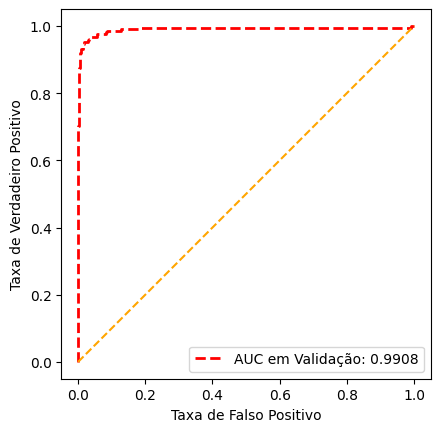

In [ ]:
# Plot
plot_roc('AUC em Validação: {0:.4f}'.format(auc_score_val), val_label_auc , val_pre_auc , color="red", linestyle='--')
plt.legend(loc='lower right')